<a href="https://colab.research.google.com/github/RH00000/UH_RTS_Research_ML/blob/main/CNN_CIFAR10_Optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [10]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [11]:
(x_data, y_data), (x_test, y_test) = cifar10.load_data()

x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)


print("x_train shape: ", x_train.shape)
print("x_val shape: ", x_val.shape)
print("x_test shape: ", x_test.shape)

print("y_train shape: ", y_train)
print("y_val shape: ", y_val)
print("y_test shape: ", y_test)

x_train shape:  (40000, 32, 32, 3)
x_val shape:  (10000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)
y_train shape:  [[6]
 [7]
 [8]
 ...
 [1]
 [9]
 [3]]
y_val shape:  [[2]
 [7]
 [1]
 ...
 [5]
 [9]
 [0]]
y_test shape:  [[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]


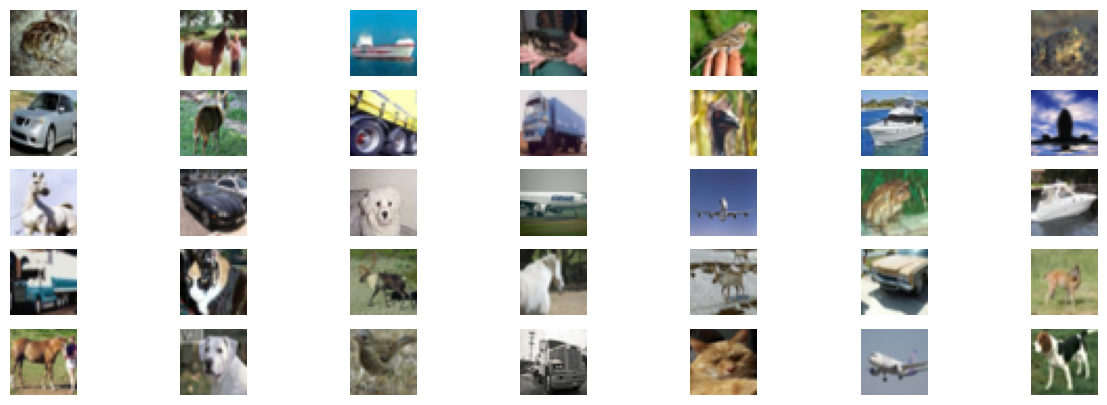

In [12]:
plt.figure(figsize=(15, 5))

num_rows = 5
num_cols = 7

#plot each of the images in the batch
for i in range(num_rows*num_cols):
  ax = plt.subplot(num_rows, num_cols, i+1)
  plt.imshow(x_train[i,:,:])
  plt.axis("off")

In [13]:
#normalize images to the range [0,1]
x_train = x_train.astype("float32") / 255
x_val = x_val.astype("float32") / 255
x_test = x_test.astype("float32") / 255

#changing y batches from integer to one hot encoding
print("Original (integer) label for the first training sample: ", y_train[0])

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

#uses interger label
print("One-hot encoded label for training dataset: ", y_train[0])

#Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

datagen.fit(x_train)

Original (integer) label for the first training sample:  [6]
One-hot encoded label for training dataset:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [14]:
def cnn_model_optimized(input_shape=(32,32,3)):
  model = Sequential()

  #Block 1: 32 filters, maxpooling,  dropout
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
  model.add(BatchNormalization())    #speeds up training
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  #Block 2: 64 filters, maxpooling
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  #Block 3: 64 filters, maxpooling
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  #Final Block
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))

  return model

In [15]:
#Create model
model_optimized = cnn_model_optimized()
model_optimized.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,13

 Total params: 672,426 (2.57 MB)

 Trainable params: 670,890 (2.56 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [16]:
model_optimized.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
             EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)]

In [18]:
print(x_train.shape)
print(y_train.shape)

(40000, 32, 32, 3)
(40000, 10)


In [19]:
history = model_optimized.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=40,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 277s 864ms/step - accuracy: 0.2978 - loss: 2.3070 - val_accuracy: 0.2003 - val_loss: 3.1668 - learning_rate: 0.0010
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 314s 838ms/step - accuracy: 0.5188 - loss: 1.3599 - val_accuracy: 0.6038 - val_loss: 1.1041 - learning_rate: 0.0010
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 327s 856ms/step - accuracy: 0.6122 - loss: 1.0881 - val_accuracy: 0.6854 - val_loss: 0.8984 - learning_rate: 0.0010
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 323s 860ms/step - accuracy: 0.6610 - loss: 0.9512 - val_accuracy: 0.7089 - val_loss: 0.8244 - learning_rate: 0.0010
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 321s 858ms/step - accuracy: 0.6981 - loss: 0.8623 - val_accuracy: 0.6854 - val_loss: 0.8887 - learning_rate: 0.0010
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 261s 834ms/step - accuracy: 0.7265 - loss: 0.7919 - val_accuracy: 0.7514 - val_loss: 0.7094 - learning_rate: 0.0010
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 268s 856ms/step - accura

In [23]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, 22])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

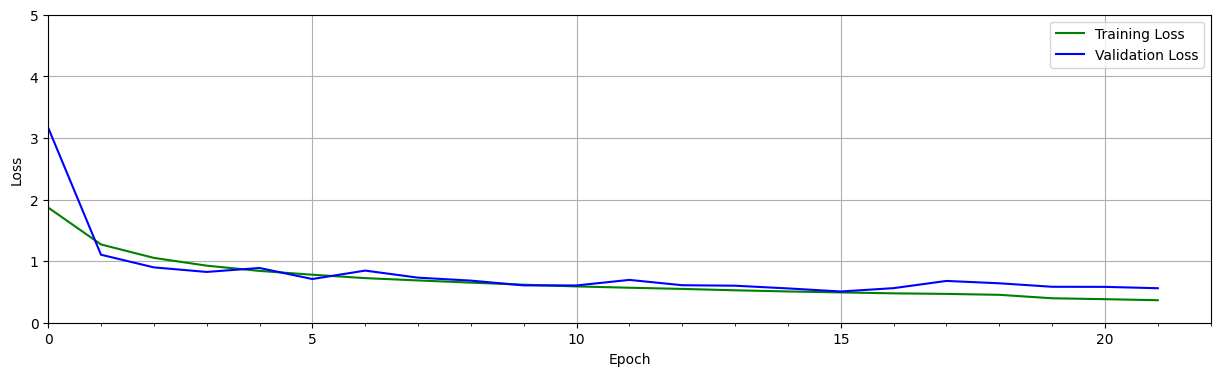

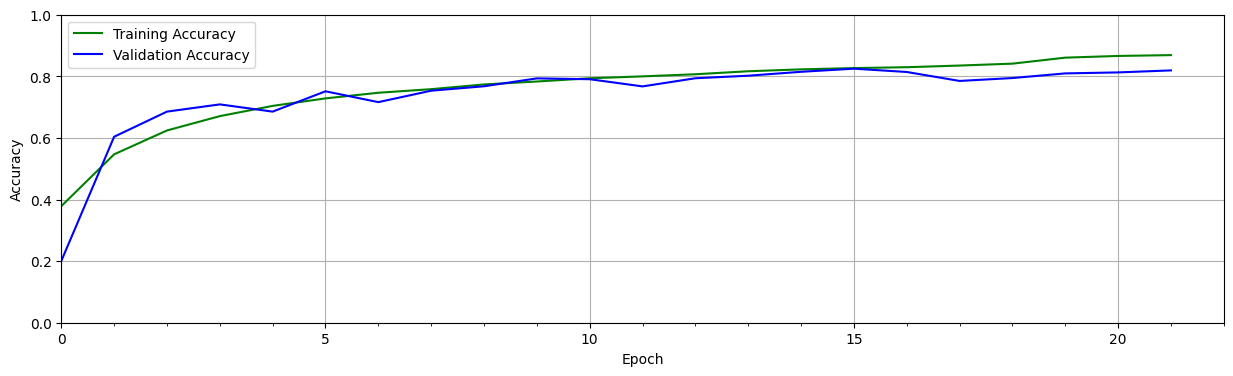

In [24]:
#Plot training results.
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

plot_results([train_loss, valid_loss],
             ylabel='Loss',
             ylim=[0.0, 5.0],
             metric_name=['Training Loss', 'Validation Loss'],
             color=['g','b'])

plot_results([train_acc, valid_acc],
             ylabel='Accuracy',
             ylim = [0.0, 1.0],
             metric_name=['Training Accuracy', 'Validation Accuracy'],
             color=['g','b'])

In [25]:
#Using save() method to save the model to the file system in the '.keras' format
model_optimized.save('model_optimized.keras')

In [27]:
#Saving to local machine
from google.colab import files
files.download('model_optimized.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
#Load the saved model to evaluate
from tensorflow.keras import models
reloaded_model_optimized = models.load_model('model_optimized.keras')

In [31]:
test_loss, test_acc = reloaded_model_optimized.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8179 - loss: 0.5375
Test accuracy: 81.670


In [32]:
#Model evaluation (copied)
def evaluate_model(dataset, model):

    class_names = ['airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck' ]
    num_rows = 3
    num_cols = 6

    # Retrieve a number of images from the dataset.
    data_batch = dataset[0:num_rows*num_cols]

    # Get predictions from model.
    predictions = model.predict(data_batch)

    plt.figure(figsize=(20, 8))
    num_matches = 0

    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(data_batch[idx])

        pred_idx = tf.argmax(predictions[idx]).numpy()
        truth_idx = np.nonzero(y_test[idx])

        title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
        title_obj = plt.title(title, fontdict={'fontsize':13})

        if pred_idx == truth_idx:
            num_matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')

        acc = num_matches/(idx+1)
    print("Prediction accuracy: ", int(100*acc)/100)

    return

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
Prediction accuracy:  0.94


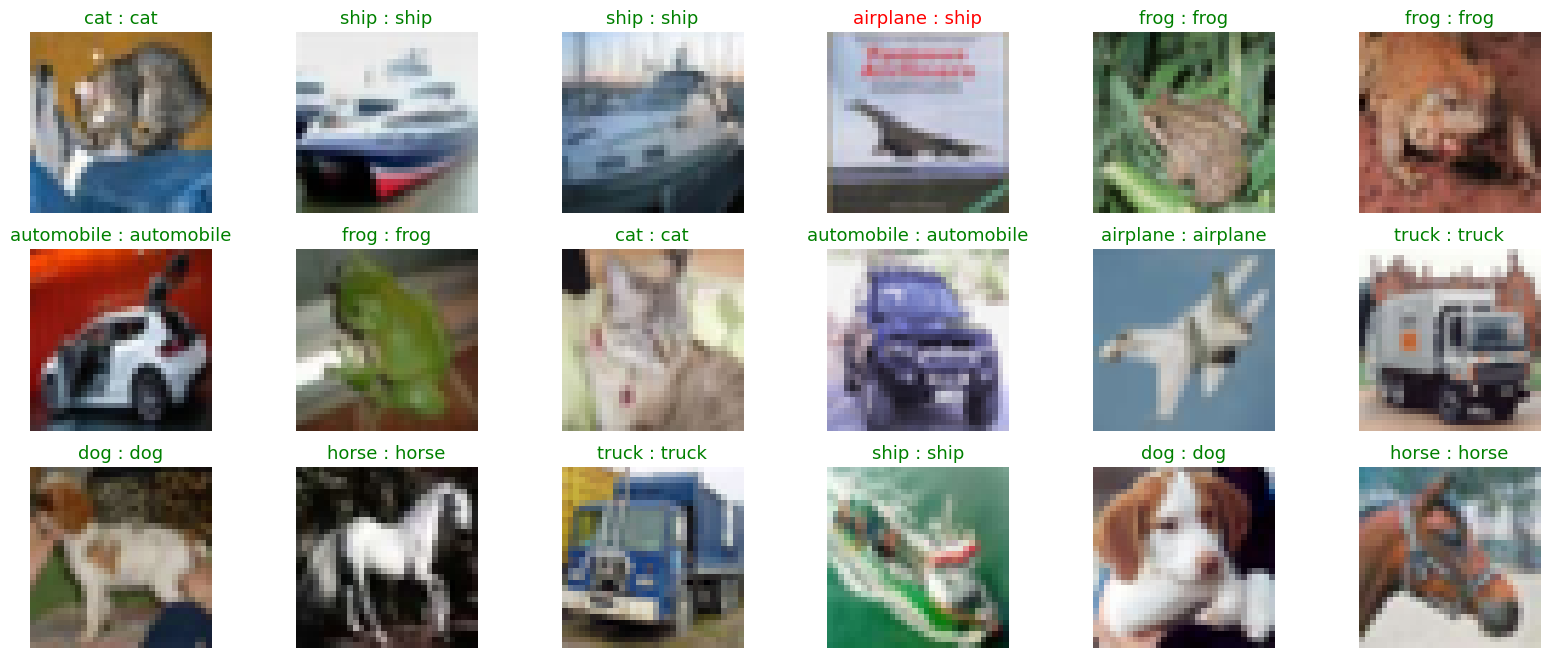

In [33]:
evaluate_model(x_test, reloaded_model_optimized)

In [35]:
#Generate predictions for the test dataset
predictions = reloaded_model_optimized.predict(x_test)

#For each sample image in test dataset, select class label with the highest probability
predicted_labels = [np.argmax(i) for i in predictions]

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step


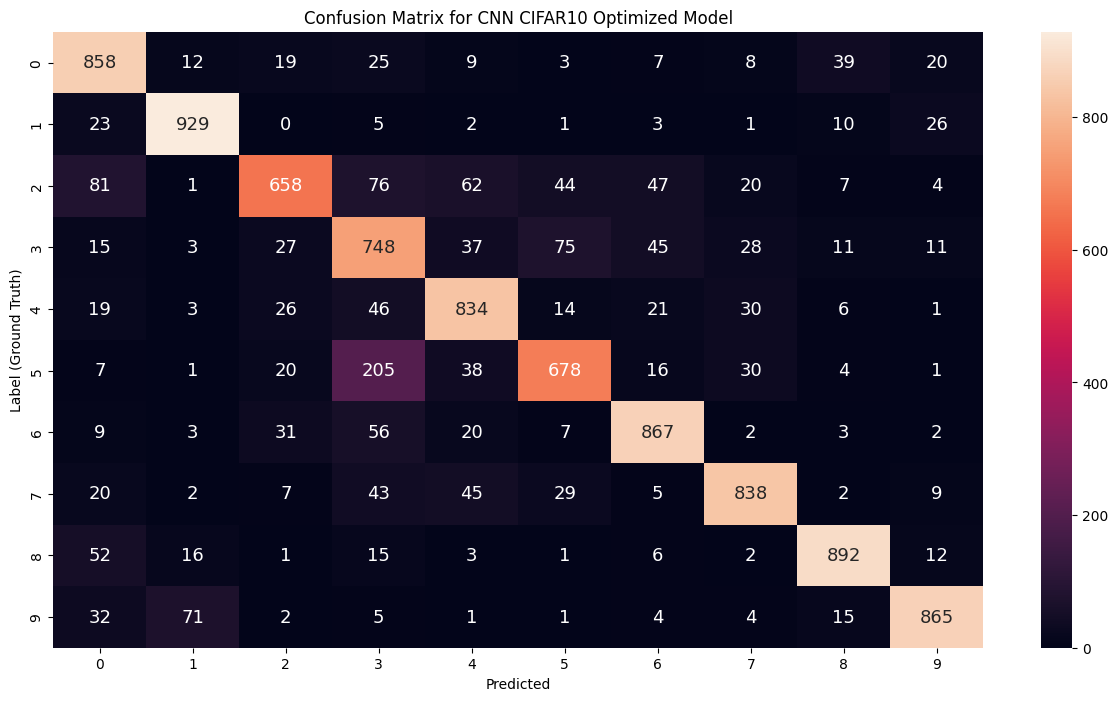

In [36]:
#Convert one-hot encoded labels to integers
y_test_integer_labels = tf.argmax(y_test, axis=1)

#Generate a confusion matrix for test data
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

#Plot the confusion matrix as a heatmap
plt.figure(figsize=[15,8])

import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 13})
plt.title('Confusion Matrix for CNN CIFAR10 Optimized Model')
plt.xlabel('Predicted')
plt.ylabel('Label (Ground Truth)')
plt.show()